<a href="https://colab.research.google.com/github/shreyamanapure/shreyamanapure/blob/main/Blindness_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyamanapure8","key":"e2d532605bad136a1b8c60b5ec48c829"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

 92% 218M/238M [00:03<00:00, 48.7MB/s]
100% 238M/238M [00:03<00:00, 75.4MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diabetic-retinopathy-224x224-2019-data.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [8]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
Data = '/content/Data/colored_images'

In [10]:
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    Data,
    # shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

test_df= tf.keras.preprocessing.image_dataset_from_directory(
    Data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 3662 files belonging to 5 classes.
Using 2930 files for training.
Found 3662 files belonging to 5 classes.
Using 732 files for validation.


In [11]:
class_names = train_df.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

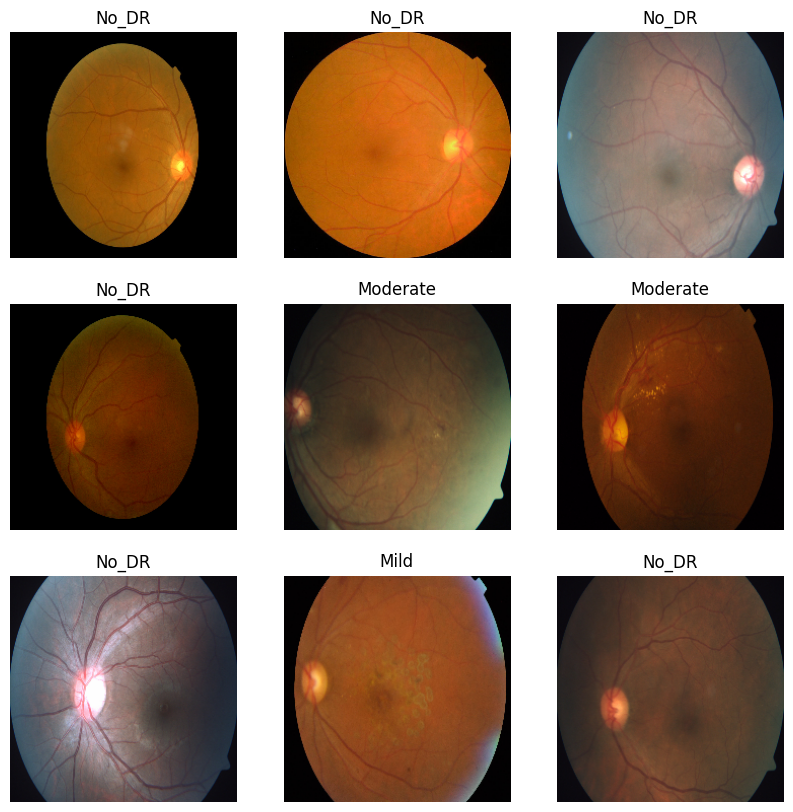

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis('off')

In [13]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224,224,3),
classes=5,
include_top=False,
weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [14]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [15]:
data_augmentation = keras.models.Sequential([
keras.layers.RandomFlip('horizontal'),
keras.layers.RandomRotation(0.2)
])

In [16]:

num_classes = len(class_names)

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [17]:
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 5)                 2885      
                                                                 
Total params: 942,005
Trainable params: 2,885
Non-trainable p

In [18]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=1, verbose=1, mode='auto')

check = ModelCheckpoint(monitor='val_accuracy',filepath="./bestmodel.h5", save_best_only=True, verbose=1, mode='auto')

call = [early,check]

In [19]:
history = model.fit(train_df,
validation_data=test_df,
epochs=15,
callbacks=call)

Epoch 1/15
92/92 [==============================] - ETA: 0s - loss: 1.1467 - accuracy: 0.5792
Epoch 1: val_accuracy improved from -inf to 0.70902, saving model to ./bestmodel.h5
92/92 [==============================] - 21s 92ms/step - loss: 1.1467 - accuracy: 0.5792 - val_loss: 0.8257 - val_accuracy: 0.7090
Epoch 2/15
91/92 [============================>.] - ETA: 0s - loss: 0.8394 - accuracy: 0.7009
Epoch 2: val_accuracy improved from 0.70902 to 0.72678, saving model to ./bestmodel.h5
92/92 [==============================] - 7s 74ms/step - loss: 0.8399 - accuracy: 0.7010 - val_loss: 0.7209 - val_accuracy: 0.7268
Epoch 3/15
91/92 [============================>.] - ETA: 0s - loss: 0.7471 - accuracy: 0.7332
Epoch 3: val_accuracy improved from 0.72678 to 0.74590, saving model to ./bestmodel.h5
92/92 [==============================] - 8s 79ms/step - loss: 0.7469 - accuracy: 0.7334 - val_loss: 0.6753 - val_accuracy: 0.7459
Epoch 4/15
90/92 [============================>.] - ETA: 0s - loss: 0

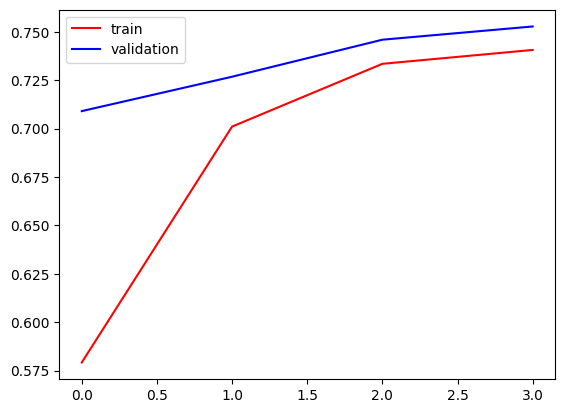

In [20]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

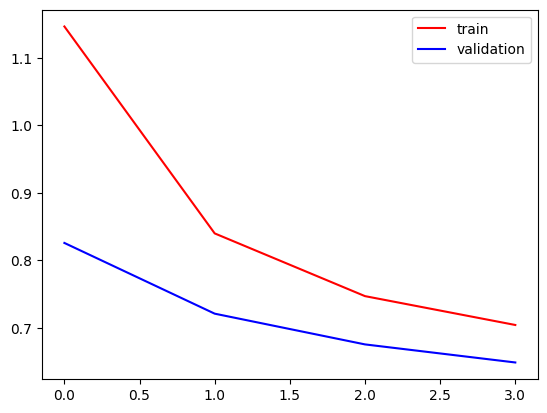

In [21]:

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(test_df)
print('test accuracy : ', test_acc)

23/23 [==============================] - 3s 70ms/step - loss: 0.6485 - accuracy: 0.7527
test accuracy :  0.7527322173118591


In [31]:
results = model.evaluate(test_df, verbose=0)

In [32]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.64848
Accuracy on the test set: 75.27%


1/1 [==============================] - 1s 817ms/step


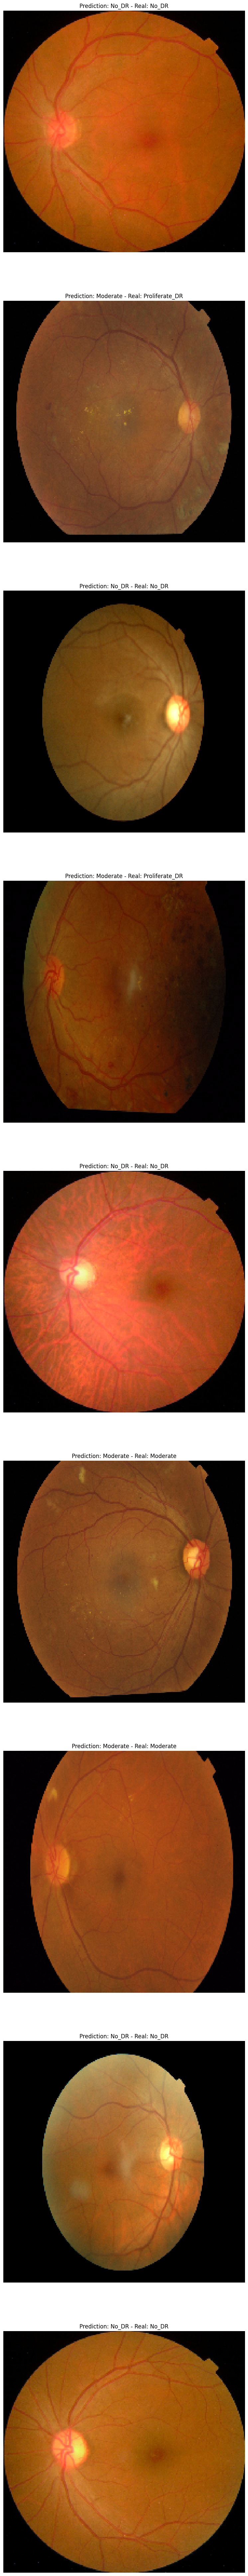

In [34]:
plt.figure(figsize=(10, 100))
for images, labels in test_df.take(1):
  prediction = model.predict(images,batch_size=32)
  for i in range(9):
    ax = plt.subplot(9, 1, i+1)
    pred = np.argmax(prediction[i])
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(f'Prediction: {class_names[pred]} - Real: {class_names[labels[i].numpy()]}')
    plt.axis('off')